# Klasyczny model Isinga
Model, wprowadzony na początku lat 20. XX wieku przez Ernsta Isinga, pierwotnie miał być modelem ferromagnetyzmu. Od tego czasu stał się fundamentem zrozumienia przejść fazowych i emergentnych właściwości w różnych układach fizycznych. Co ciekawe, znalazł zastosowania również poza fizyką - znajduje zastosowania w takich dziedzinach jak finanse, dynamika społeczna oraz optymalizacja w zagadnieniach Informatycznych. W tym kursie skupimy się na jednym problemie z nim związanym: znalezieniu stanu podstawowego (tj. stanu o najniższej energii) modelu Isinga oraz widma niskich energii.


## Definicja

Rozważmy wektor zmiennych binarnych $\bm{s} = (s_1, s_2, \ldots, s_N)$, gdzie $s_i = \pm 1$. Zmienne te nazywane są **spinami** i mogą przyjmować jeden z dwóch stanów: w górę ($+1$) lub w dół ($-1$). Spiny są rozmieszczone na pewnym grafie prostym $G$, który opisuje interakcje między nimi. Krawędzie grafu $G$ (oznaczane jako $E(G)$) określają, które spiny oddziałują ze sobą. Siła interakcji (lub *coupling*) między $s_i$ a $s_j$ jest oznaczana jako $J_{ij} \in \mathbb{R}$. Dodatkowo każdy spin poddawany jest działaniu zewnętrznego pola magnetycznego (lub *bias* albo *obciążenie*) $h_i \in \mathbb{R}$,  $\bm{h} = (h_1, h_2, \ldots, h_N)$. Energia układu opisana jest następującą funckją (**hamiltonianem**):

$$
H(\bm{s}) = \sum_{(i, j) \in E(G)} J_{ij} s_i s_j + \sum_{i=1}^{N} h_i s_i
$$

Każda realizacja $\bm{s}$ jest nazywana **stanem** albo **konfiguracją**. Trójkę $(G, J, h)$ nazywamy **instancją**.

## Pierwsza instancja

Zaczniemy od utworzenia instancji. Następnie policzymy jej energię ze wzoru i metodą macierzową.

TODO: Write better

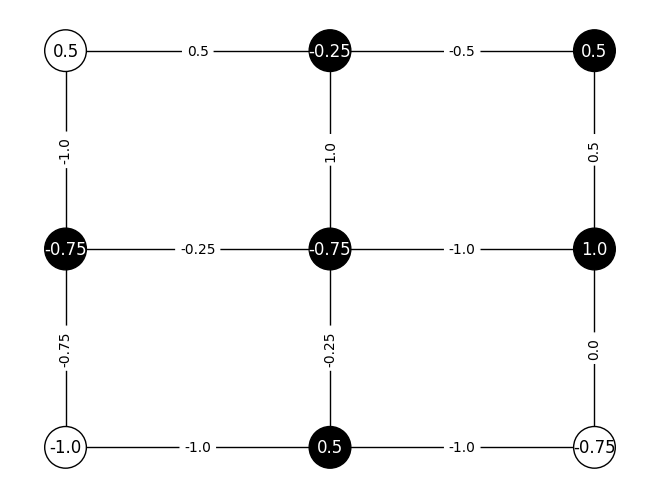

In [1]:
# Instancja razem z obrazkiem

import random
import networkx as nx
import matplotlib.pyplot as plt

random.seed(7)

# Tworzymy graf
instance = nx.grid_2d_graph(3, 3)

# Nadajemy losowe wartości spinu, h i J
nx.set_node_attributes(instance, {node: random.choice([-1, 1]) for node in instance.nodes}, "spin")
nx.set_node_attributes(instance, {node: random.choice([i / 4 for i in range(-4, 5)]) for node in instance.nodes}, "h")
nx.set_edge_attributes(instance, {edge: random.choice([i / 4 for i in range(-4, 5)]) for edge in instance.edges}, "J")

# Ustalamy kolor wierzchołków w zalezności od wartości spinu, -1 (dół) czarny i +1 (góra) biały
node_colors = ["white" if instance.nodes[node]["spin"] == 1 else "black" for node in instance.nodes]


# Rysujemy instancję, której będziemy używać
pos={node: node for node in instance.nodes}
nx.draw(instance, pos, node_color=node_colors,  node_size=900, font_weight='bold')

# rysujemy wierzchołki i pokazujemy wartość h na nich
node_labels = {node: f"{instance.nodes[node]['h']}" for node in instance.nodes}
for node in instance.nodes:
    label = f"{instance.nodes[node]['h']}"
    x, y = pos[node]  
    font_color = "white" if instance.nodes[node]["spin"] == -1 else "black"
    plt.text(x, y, label, fontsize=12, ha='center', va='center', color=font_color)
ax = plt.gca() # to get the current axis
ax.collections[0].set_edgecolor("black") 

# wpisujemy wartości "J" na krawędziach
edge_labels = {(u, v): f"{data['J']}" for u, v, data in instance.edges(data=True)}
nx.draw_networkx_edge_labels(instance, pos, edge_labels=edge_labels)

plt.show()

### Energia obliczana ze wzoru $H(\bm{s}) = \sum_{(i, j) \in E(G)} J_{ij} s_i s_j + \sum_{i=1}^{N} h_i s_i$

In [2]:
# Obliczenie energii ze wzoru

spins = {node: instance.nodes[node]["spin"] for node in instance.nodes}
h = {node: instance.nodes[node]["h"] for node in instance.nodes}
J = {(u, v): data['J'] for u, v, data in instance.edges(data=True)}

def navie_energy_calculation(spins, J, h, instance):
    # Liczymy w dwóch pętlach
    energy_naive = 0

    # Część liniowa
    for node in instance.nodes:
        energy_naive += spins[node] * h[node]

    # Część kwadratowa
    for (u, v) in instance.edges:
        energy_naive += spins[u] * spins[v] * J[(u, v)]

    return energy_naive

energy_naive = navie_energy_calculation(spins, J, h, instance)
print(f"Wartość energii wynosi: {energy_naive}")

Wartość energii wynosi: 1.25


### Metoda macierzowa
Z punktu widzenia efektywności obliczeń, warto skorzystać z narzędzi algebry liniowej. Rozważmy macierz sąsiedztwa grafu $G$, przyjmując każdy $J_{ij}$ jako wagę przypisaną do krawędzi. Ponieważ graf $G$ jest grafem prostym, jest on grafem nieskierowanym, więc wartości $J_{ij} = J_{ji}$. Symetria względem przekątnej pozwala nam na uproszczenia (i uniknięcie zbędnej pracy) - możemy zająć się jedynie elementami $J_{ij}$, gdzie $i < j$, to znaczy macierzą górnotrójkątną. Zwyczajowo oznaczaną jako $\bm{J}$. Wówczas równanie hamiltonianu $H(\bm{s})$ przyjmuje postać:

$$
H(\bm{s}) = \bm{s}\bm{J}\bm{s}^{T} + \bm{h}\bm{s}^{T}
$$


In [4]:
# Obiczenie energii w wersji macierzowej
import numpy as np

# Zamiana grafowej reprezentacji na macierzową. 
# UWAGA: od wersji python 3.7 słowniki zachowują kolejność, więc możemy bezpiecznie zamieniać je na vektory
def dict_to_vect(d: dict):
    return np.array(list(d.values()))

spins_vector = dict_to_vect(spins)
h_vector = dict_to_vect(h)

# Macierz górnotrójkątna J
def dict_to_matrix(instance: nx.Graph, J: dict):
    n = len(instance)
    J_matrix = np.zeros(shape=(n,n))
    renum = {node: idx for idx, node in enumerate(instance.nodes)}
    for (u, v), J_value in J.items():
        i = renum[u]
        j = renum[v]
        if i > j:
            i, j = j, i
        J_matrix[i, j] = J_value
    return J_matrix

J_matrix = dict_to_matrix(instance, J)

# Liczymy energię z kolejnego wzoru
energy_vectorized = spins_vector @ J_matrix @ spins_vector.T + spins_vector @ h_vector
print(f"Wartość energii wynosi: {energy_vectorized}")



Wartość energii wynosi: 1.25


### Czym się różnią te metody?

Chociaż mamy do czynienia z różnymi przedstawieniami tej samej funkcji, dającymi takie same wyniki, to ich efektywność znacznie się różni. O ile wykonanie obliczeń w obu przypadkach było bardzo szybkie, to dla dużych instancji liczenie energii metodą macierzową jest zauważalnie szybsze. Różnice wywołane są wykorzystaniem biblioteki NumPy, która posiada efektywne niskopoziomowe implementacje obliczeń na macierzach.

In [15]:
import timeit

# Przygotujmy dużą losową instancję

big_instance = nx.complete_graph(1000)

# Nadajemy losowe wartości spinu, h i J
nx.set_node_attributes(big_instance, {node: random.choice([-1, 1]) for node in big_instance.nodes}, "spin")
nx.set_node_attributes(big_instance, {node: random.choice([i / 4 for i in range(-4, 5)]) for node in big_instance.nodes}, "h") 
nx.set_edge_attributes(big_instance, {edge: random.choice([i / 4 for i in range(-4, 5)]) for edge in big_instance.edges}, "J")

# Powtarzamy poprzednie procedury
spins_big = {node: big_instance.nodes[node]["spin"] for node in big_instance.nodes}
h_big = {node: big_instance.nodes[node]["h"] for node in big_instance.nodes}
J_big = {(u, v): data['J'] for u, v, data in big_instance.edges(data=True)}

spins_big_vector = dict_to_vect(spins_big)
h_big_vector = dict_to_vect(h_big)
J_big_matrix = dict_to_matrix(big_instance, J_big)

num_runs = 10
time1 = timeit.timeit(lambda: navie_energy_calculation(spins_big,J_big, h_big, big_instance), number=num_runs)
time2 = timeit.timeit(lambda: spins_big_vector @ J_big_matrix @ spins_big_vector.T + spins_big_vector @ h_big_vector, number=num_runs)

print(f"Przeciętny czas obliczeń dla metody naiwnej używając {num_runs} wywołań: {time1 / 100:.6f} sekund")
print(f"Przeciętny czas obliczeń dla metody macierzowej używając {num_runs} wywołań: {time2 / 100:.6f} sekund")
print(f"W analizowanym przypadku metoda macierzowa jest {time1/time2:.0f} razy szybsza")


Przeciętny czas obliczeń dla metody naiwnej używając 10 wywołań: 0.016454 sekund
Przeciętny czas obliczeń dla metody macierzowej używając 10 wywołań: 0.000072 sekund
W analizowanym przypadku metoda macierzowa jest 228 razy szybsza


##### **W dalszej części tego szkolenia będziemy używać metody macierzowej do liczenia energii!**

## Interpretacja fizyczna modelu Isinga

Tradycyjnie w fizyce model Isinga opisuje się na $d$-wymiarowej sieci (w naszej definicji graf $G$). W modelu ferromagnetyzmu, będącym pierwotnym badaniem Isinga, można wyobrazić sobie węzły sieci jako atomy materiału magnetycznego. Każdy atom posiada moment magnetyczny (spin), który może być skierowany albo „w górę”, albo „w dół”. W ten sposób, jeśli wszystkie węzły są skierowane „w górę” lub „w dół”, mamy do czynienia z ferromagnetykiem. Z kolei, jeśli wszystkie sąsiednie węzły są skierowane w przeciwnych kierunkach, powstaje antyferromagnetyk, charakteryzujący się brakiem (lub zanikiem) magnetyzacji. W tej interpretacji $h_i$ reprezentuje zewnętrzne pole magnetyczne, które wymusza skierowanie momentu magnetycznego w określonym kierunku. Oddziaływania między spinami $J_i$ mogą być ferromagnetyczne, jeśli sprzyjają skierowaniu sąsiadujących węzłów w tym samym kierunku; w przeciwnym razie nazywane są antyferromagnetycznymi. Stan, w którym spiny są losowo skierowane w górę lub w dół, często nazywany jest szkłem spinowym (spin glass).

# Stany niskoenergetyczne

Jednym z podstawowych problemów dotyczących modelu Isinga jest poszukiwanie **stanu podstawowego** - stanu o najmniejszej energii. Zatem interesuje nas minimalizacja wartości Hamiltonianu:

$$
\min_{\bm{s}} H(\bm{s})
$$

W ogólności jest to problem NP-trudny.




## Problemu podziału jako model Isinga

Formalnie: mając dany zbiór $N$ dodatnich liczb całkowitych $S = \lbrace n_1, \ldots, n_N \rbrace$, chcemy znaleźć dwa rozłączne podzbiory $X, Y \subset S$, $X \cap Y = \emptyset$, $X \cup Y = S$ takie, że sumy ich elementów są sobie równe tj.
$$
\sum_{n \in X}n = \sum_{n' \in Y} n'  \Leftrightarrow \sum_{n \in X}n - \sum_{n' \in Y} n'=0
$$
bądź też różnica jest minimalna (nie zawsze rozwiązanie optymalne istnieje). Hamiltonian przyjmuje postać

$$
H = A (\sum_{i=1}^N n_i s_i)^2
$$

gdzie $n_i \in S$, $s_i = \pm 1$ oraz $A > 0$ jest pewną stałą. Widać, że optymalne rozwiązanie $H=0$ można osiągnąć tylko wtedy, gdy suma $n_i$ stojących przy spinach $+1$ jest równa sumie $n_i$ stojących przy spinach $-1$. 

Podany Hamiltonian $H$ jest Hamiltonianem Isinga, widać to po pewnych przekształceniach

$$
H = A (\sum_{i=1}^N n_i s_i)^2 = A(\sum_{i,j} 2 n_i n_j s_i s_j + \sum_{i=1}^N n_i^2 s_i^2) = A \sum_{i,j} J_{ij} s_i s_j + C
$$

gdzie $C=A\sum_{i=1}^N n_i^2 s_i^2$ jest pewną stałą, która nie ma wpływu na rozwiązanie, a $J_{ij} = 2 n_i n_j$.

#### O problemie podziału mniej formalnie i wyprowadzenie Hamiltonianu

Problem podziału najłatwiej będzie wyjaśnić na życiowym przykładzie - podziale spadku. Na majątek składa się biżuteria, książki, antyki. Mamy dwóch spadkobierców, każdy ma otrzymać taką samą wartość majątku. Zakładamy, że przedmiotów nie można "rozmieniać" ani sprzedać, należy rozdać cały majątek. Jak dokonać tego najbardziej sprawiedliwie? Dobrać podział tak, aby różnica była możliwie najmniejsza.

Spróbujemy przedstawić ten problem za pomocą Hamiltonianu. Optymalne rozwiązanie zakłada równy podział (różnica wynosi 0), natomiast nas będzie interesować minimalna różnica:
$$
\vert\sum_{n \in X}n - \sum_{n' \in Y} n'\vert= \min  \Leftrightarrow \vert\sum_{n \in X}1\cdot n + \sum_{n' \in Y} (-1)\cdot n'\vert=\min 
$$
$$
\vert\sum_{n \in S}(\pm1)n\vert= \vert\sum_{i=1}^N n_i s_i\vert=\min \Leftrightarrow (\sum_{i=1}^N n_i s_i)^2=\min, 
$$
gdzie
$s_i=1$ oznacza, że $n_i \in X$, a $s_i=-1$, że $n_i\in Y$. 



In [ ]:
## Przykładowy problem podziału
## rozwiążemy go metodą wyczerpującego przeszukiwania - sprawdzanie wszystkich możliwości
import numpy as np
from itertools import product
from math import inf

# zadany zbiór
S = [2, 3, 4, 5, 6] 

def calculate_hamiltonian(S, spins, A = 1):
    return A * sum([S[i] * spins[i] for i in range(len(S))])**2

best_energy = inf
best_solution = None
for solution in product([-1, 1], repeat=len(S)):
    energy = calculate_hamiltonian(S, solution)
    if energy < best_energy:
        best_energy = energy
        best_solution = solution

S_1 = []
S_2 = []
for idx, spin in enumerate(best_solution):
    if spin == 1:
        S_1.append(S[idx])
    elif spin == -1:
        S_2.append(S[idx])
    else:
        raise ValueError("Coś zlego się stało ze spinem")

print("Najlepsza znaleziona wartość Hamiltonianu: ", best_energy)
print("Rozwiązanie: ", best_solution)
print("Podział: ", S_1, S_2)


Najlepsza znaleziona wartość Hamiltonianu:  0
Rozwiązanie:  (-1, -1, 1, -1, 1)
Podział:  [4, 6] [2, 3, 5]


: 

## Rozwiązanie problemu Isinga?

Istnieje wiele algorytmów przeznaczonych do rozwiązania tego problemu. Na tym szkoleniu skupimy się na wybranych algorytmach klasycznych takich jak:    

* Przeszukiwanie wyczerpujące
* Symulowane wyżarzanie
* Wyżarzanie równoległe
* Branch and bound
* Symulowana bifurkacja

Oraz na metodzie **wyżarzania kwantowego** razem z zastosowaniem wyżarzaczy kwantowych firmy D-Wave. 


# Literatura

- Dowolny podręcznik poświęcony mechanice statystycznej (ex. Luca Peliti: Statistical Mechanics in a Nutshell, R.J. Baxter: Exactly Solved Models in Statistical Mechanics, H.E. Stanley: Introduction to Phase Transitions and Critical Phenomena etc.)
- Cipra, B. A. (1987). An introduction to the Ising model. *The American Mathematical Monthly*, 94(10), 937-959.
- Lucas, A. (2014). Ising formulations of many NP problems. *Frontiers in Physics*, Volume 2
